In [1]:
from torchvision import datasets, transforms
import torchvision
import torch
from net import AlexNetPlusLatent
from net import ResNetPlusLatent
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
%matplotlib inline

In [2]:
bits = 48
pretrained = 91.33
weights_folder = './weights'

In [3]:
#net = AlexNetPlusLatent(bits)
net = ResNetPlusLatent(bits)
#net.load_state_dict(torch.load(weights_folder + '/AlexNet/91.33'))
#net.load_state_dict(torch.load(weights_folder + '/ResNet18/95.8'))
#net.load_state_dict(torch.load(weights_folder + '/ResNet50/96.08'))
net.load_state_dict(torch.load(weights_folder + '/ResNet50a/94.14'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Use device: ' + str(device))
net.to(device)
net.eval()

Use device: cuda:0


ResNetPlusLatent(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

In [4]:
def load_data(trans=1):
    transform_test = transforms.Compose(
        [
         transforms.Resize(227),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ]
    )
    
    transform_vis = transforms.Compose(
        [
         #transforms.Resize(32),
         transforms.ToTensor()
        ]
    )
    if trans:
        testset = datasets.CIFAR10(root='./data', train=False, download=True,
                                   transform=transform_test)
        _loader = torch.utils.data.DataLoader(testset)
    else:
        visset = datasets.CIFAR10(root='./data', train=False, download=True,
                                  transform=transform_vis)
        _loader = torch.utils.data.DataLoader(visset)
        
    return _loader

In [5]:
def int32_single_output(_data):
    _tensor = (single_output(_data)[0,:]>0.5).int()
    _str = ''
    for i in range(0, _tensor.shape[0]):
        _str += str(int(_tensor[i]))
    _int = int(_str, 2)
    return _int

In [6]:
def int32_aggregate_output(_loader):    
    #var intitialization
    _output = []    
    _transform = transforms.Compose([transforms.Scale(32), transforms.ToTensor()])
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(_loader):            
            _int = int32_single_output(inputs)
            b = (batch_idx, _int, int(targets) , inputs)
            if batch_idx%100==0:
                print('.', end='')
            _output.append(b)
        return _output

In [7]:
def find_picutre(given_pic_id, _list, _id_place=0):
    _output = [item for item in _list if item[_id_place] == given_pic_id]
    return _output[0]

In [8]:
def single_output(data):
    inputs = data.to(device)
    outputs, _ = net(inputs)
    return outputs.data

In [9]:
def hammingDistance(x, y):
    ans = 0
    for i in range(31,-1,-1):
        b1= x>>i&1
        b2 = y>>i&1
        ans+= not(b1==b2)
    return ans

In [10]:
def tpr(hash_list, _given_pic_class, ):
    #var initialization
    _tp = 0
    _fn = 0
    
    for (_, _, _list_pic_class) in hash_list:
        #identify TP, FP, FN
        if _given_pic_class == _list_pic_class:
            _tp += 1
        else:
            _fn += 1
    
    _tpn = _tp/(_tp + _fn)
    return _tp, _fn, _tpn

In [11]:
def overal_AP(hash_list, _given_pic_class):
    #var initialization
    _overal_AP = 0.0
    i = 0
    _tp = 0
        
    for (_, _, _list_pic_class, _) in hash_list:
        i += 1
        if _given_pic_class == _list_pic_class:
            _tp += 1
            _overal_AP += _tp/i
        
    return _overal_AP/_tp

In [12]:
def n_most_relative(_given_pic_id, hash_list, _num_of_pictures):
    #find given picture
    _given_pic = find_picutre(_given_pic_id, hash_list)
    
    #var initialization
    _output = []
    
    #extract given picture properties
    _given_pic_hash = _given_pic[1]
    _given_pic_class = _given_pic[2]
      
    for _list_pic in hash_list:        
        #extract list picture properties
        _list_pic_id = _list_pic[0]
        if (_given_pic_id != _list_pic_id):
            _list_pic_hash = _list_pic[1]
            _list_pic_class = _list_pic[2]
            _pic = _list_pic[3][0].numpy()
            _pic = np.transpose(_pic, (1, 2, 0))        

            #compute hamming distance
            _hamming_distance = hammingDistance(_given_pic_hash, _list_pic_hash)


            b = (hash_list[_list_pic_id][0], _hamming_distance, _list_pic_class, _pic)
            _output.append(b)
        
    #sort and crop output
    _pic = _given_pic[3][0].numpy()
    _pic = np.transpose(_pic, (1, 2, 0))
    
    _output = sorted(_output, key=lambda tup: tup[1])[0: _num_of_pictures]
    _output.insert(0,(_given_pic_id, 0, _given_pic_class, _pic))
    
    #compute TP, FN, TPN
    #_tp, _fn, _tpn = tpr(_output, _given_pic_class)
    
    #compute Overal AP
    _overal_AP = overal_AP(_output, _given_pic_class)
    #print('Overal AP:', _overal_AP)
    
    return _overal_AP, _output

In [13]:
def visualize(images, columns=10):
    img = images[1][0][3]
    img = (img *(0.2023, 0.1994, 0.2010)+(0.4914, 0.4822, 0.4465))*255
    fig=plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(img.astype(np.uint8))
    plt.show()
    
    rows = math.ceil(len(images[1])/columns)
    fig=plt.figure(figsize=(columns,rows))
    i = 1
    for (_,_,_, image) in images[1]:        
        img = (image*(0.2023, 0.1994, 0.2010)+(0.4914, 0.4822, 0.4465))*255
        fig.add_subplot(rows, columns, i)
        plt.subplots_adjust(hspace = 0,wspace = 0)
        plt.axis('off')
        plt.imshow(img.astype(np.uint8))
        if i%columns==0:
            #print('.', end='')
            plt.show()
            fig=plt.figure(figsize=(columns,rows))
        i += 1
           

In [14]:
_loader = load_data()
#_loader_v = load_data(0)

Files already downloaded and verified


In [15]:
hash_list = int32_aggregate_output(_loader)

c:\users\demer\miniconda3\envs\pytorch_deephash\lib\site-packages\torchvision\transforms\transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


....................................................................................................

In [16]:
def test(pic_id, n):
    _r = n_most_relative(pic_id , hash_list, n)
    visualize(_r, 13)

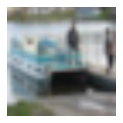

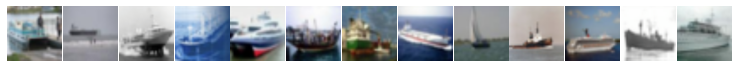

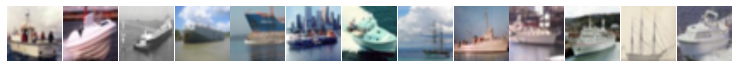

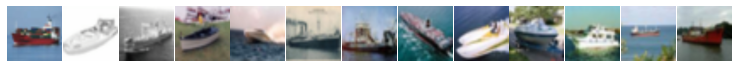

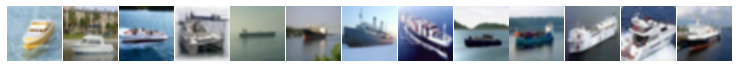

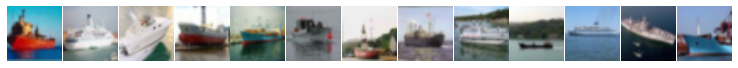

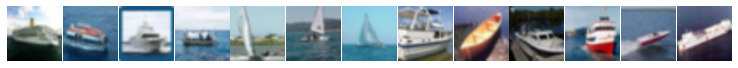

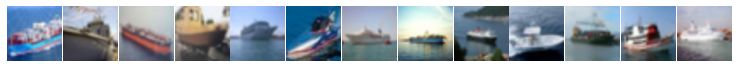

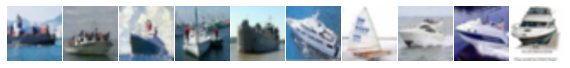

In [17]:
test(pic_id=6569, n=100)

In [18]:
len(hash_list)

10000

In [19]:
import random

def random_ids(_range=10000, m=1000, seed = 4):
    x = [*range(0, 10000)]
    random.seed(4)
    random.shuffle(x)
    x = x[0:m]
    return x

def mAP(hash_list, n, m = 1000):
    _random_ids = random_ids(10000, m, 4)
    a = 0
    i = 0
    for _id in _random_ids:
        _overal_AP , _ = n_most_relative(_id, hash_list, n)
        a += _overal_AP
        if i%5==0:
            print('.', end='')
        i += 1
    _mAP = a/m
    return _mAP

In [20]:
mAP(hash_list, n = 500, m = 500)

....................................................................................................

0.9370609810593676